In [3]:
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt, os
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
CHECKPOINT = "distilbert-base-uncased"

tokenizer = DistilBertTokenizer.from_pretrained(CHECKPOINT)
model = DistilBertForSequenceClassification.from_pretrained(CHECKPOINT)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
inps = torch.tensor([
    [1, 2, 3, 4],
    [4, 5, 6, 7],
    [1, 2, 3, 4]
])

labels = torch.tensor([1, 0, 1])

mask = torch.tensor([
    [1, 1, 1, 0],
    [1, 1, 0, 0],
    [1, 1, 1, 1]
])

In [4]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [5]:
DATA_DIR = "/Users/naman/Desktop/Code/ThesisData/Labeled_data"
FILES = [
    "1coviddetoxify0.5.csv",
    "Andhbhaktafterdetoxify.csv",
    "GobackModifinallabels1.csv",
    "Gyanvapiafterdetoxifyandcorrectedlabels.csv",
    "indianmusafterdetoxify-1.csv",
    "indianmusafterdetoxify.csv"
]

In [6]:
covid_df = pd.read_csv(f"{DATA_DIR}/{FILES[0]}")
andh_df = pd.read_csv(f"{DATA_DIR}/{FILES[1]}")

In [7]:
covid_df.head()

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,manual_label,language,Predicted Label,Toxicity Score
0,3.509657e+07,morr2theleft,914,1409,Anarchist. No gods no masters on this burning ...,"Portland, OR",Just got bills for $375 in addition to the $55...,2021-01-20 23:58:43+00:00,2,0,5,0,1.0,en,1,0.976667
1,3.505029e+07,mopsnicole,282,8921,pugs~tim burton~virgo☀️~taurus🌙~cap⬆️,NaN,I never really thought speaking out about my c...,2021-01-20 23:58:16+00:00,0,2,7,0,0.0,en,0,0.335981
2,1.240000e+18,jj0nggg,362,4688,19 learning 한국어! sh gemini 🧊🇺🇸💗,NaN,@M4SQUER4D3 I WISH I WAS STILL ON ONLINE SCHOO...,2021-01-20 23:57:18+00:00,0,0,0,0,1.0,en,1,0.584002
3,1.160000e+18,YIndigence,44,7412,Think about the things that annoy you most in ...,NaN,"@jjonezy1983 @randomyoko ""Gas prices have been...",2021-01-20 23:56:20+00:00,0,2,0,0,0.0,en,0,0.017517
4,7.220000e+17,thatfishbitch75,1408,26491,🏳️‍🌈🏳️‍⚧️| 19 | they/it/he | @squiggle64 is ki...,NaN,"// politics , trump - -I little hate when poli...",2021-01-20 23:55:02+00:00,0,2,3,0,0.0,en,0,0.146278


In [27]:
covid_df["author_id"].value_counts().head()

author_id
1.330000e+18    20
1.350000e+18    18
1.270000e+18    18
1.280000e+18    17
1.320000e+18    16
Name: count, dtype: int64

In [10]:
filt = covid_df["likes"] > 1000

covid_df[filt].iloc[0]["text"]

'4 years ago we had a healthy economy, sparse domestic threats and a stable democracy.Trump brought us a dark recession, 400,000 COVID deaths, white supremacists rallies, massive spike in hate crimes and a deadly failed coup.Trump promised American Carnage and he delivered.'

In [16]:
andh_df.head()

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,Predicted Label,manual_label,Toxicity Score
0,2.184026e+09,FairozKing,3,774,"Indian, Secular, Nationalist,",Bangalore,@AnupamPKher #AndhBhakt,2022-05-20 21:39:38+00:00,0,0,0,0,0,0.0,0.000413
1,7.984403e+17,BipBopBuu,2069,7533,1•1•1•1,In transit,This is Modistroke!#AndhBhakt https://t.co/vRP...,2022-05-20 20:59:26+00:00,0,0,0,0,0,0.0,0.000886
2,2.212610e+09,jbhandle4u,119,80244,to the point...,India,@CGattani @supriya_sule Still u will remain an...,2022-05-20 20:09:07+00:00,0,1,1,0,1,1.0,0.824712
3,1.468152e+18,PopatMaster786,2537,57261,कुछ दिन तो गुजारिए ट्विटर पर साथ में😏मजा ना आए...,यत्र तत्र सर्वत्र,@Andhbhakt_Elly https://t.co/Nve5CVrJ7e,2022-05-20 20:04:13+00:00,0,0,0,0,0,0.0,0.000402
4,8.792428e+17,Raj_poot23,1279,9820,You can let your smile change people but don't...,"प्रतापगढ़,लखनऊ, भारत🇮🇳",@Andhbhakt_Elly 😂😂🚩🙏,2022-05-20 20:00:01+00:00,0,0,2,0,0,0.0,0.000388


<Axes: >

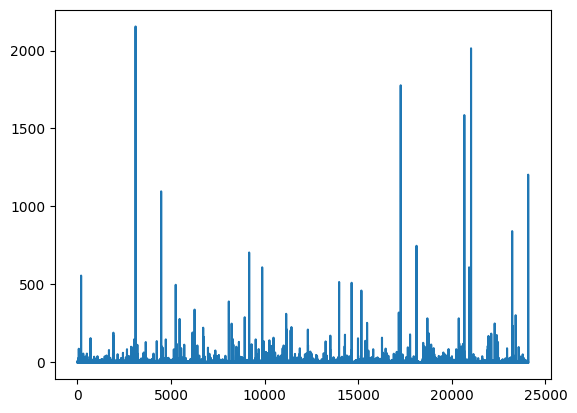

In [17]:
andh_df["likes"].plot()

In [46]:
for file in FILES:
    print(f"file: {file}")
    df = pd.read_csv(f"{DATA_DIR}/{file}")["text"].map(lambda x: len(x.split()))
    # df = df.sort_values().tail()
    # print(df.mean())
    print(len(df[df > 80]), end="\n\n")

file: 1coviddetoxify0.5.csv
0

file: Andhbhaktafterdetoxify.csv
14

file: GobackModifinallabels1.csv
0

file: Gyanvapiafterdetoxifyandcorrectedlabels.csv
5

file: indianmusafterdetoxify-1.csv
0

file: indianmusafterdetoxify.csv
1



In [9]:
os.getcwd()

'/Users/naman/Desktop/Code/Projects/ToxicityAnalysis/Naman-work'